In [ ]:
pip list | grep tensorflow

tensorflow                    2.8.0
tensorflow-addons             0.16.1
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

In [ ]:
!unzip /content/drive/"My Drive"/data_rr_intervals.zip

In [4]:
!pip install -q -U tensorflow_addons
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [33]:
import sys
import os
%matplotlib inline
sampling_rate=500
arr_folder_location = "/content/drive/MyDrive/Arrythmia /"
sys.path.append(os.path.abspath(arr_folder_location))

In [34]:
from arryhthmia_backend import *

In [12]:
# !rm -rf /content/musecare_rr_intervals #to delete a folder

In [68]:
import glob

path = r'/content/musecare_rr_intervals' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
name = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    one_list=df.iloc[0]
    new_df=pd.DataFrame()
    for i in range(0,len(one_list)):
      if(one_list[i]!=one_list[i+1]):
        one_list=one_list[i+1:i+101]
        one_list=one_list/1000
        one_list.reset_index(inplace=True,drop=True)
        detrended_rri = signal.detrend(one_list, axis= -1, type='constant', bp=0, overwrite_data=False).tolist()
        
        new_df=new_df.append(pd.DataFrame(detrended_rri).transpose())
        break
    li.append(new_df)
    name.append(filename)

test_data = pd.concat(li, axis=0, ignore_index=True)
test_data['filename']=name

print(test_data.shape[0] - test_data.dropna().shape[0])
#hence 81 files have null values, will drop them

test_data=test_data.dropna()
test_data.reset_index(inplace=True,drop=True)

81


In [69]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,filename
0,-0.009480,-0.016480,-0.010180,-0.001580,-0.001580,-0.025880,-0.026880,-0.037680,-0.020680,0.126520,...,0.009920,-0.008180,-0.005180,0.000320,-0.019680,-0.015580,-0.032580,0.009220,0.139920,/content/musecare_rr_intervals/3346.csv
1,-0.555754,-0.351054,-0.428354,-0.049054,-0.343954,-0.308354,-0.089454,-0.438854,-0.396254,-0.243354,...,0.557346,0.747246,0.049546,0.217946,-0.166754,-0.046654,-0.421654,1.225146,-0.214254,/content/musecare_rr_intervals/6910.csv
2,0.017718,0.001818,0.001018,0.016318,0.012718,-0.056582,-0.056582,-0.029982,-0.001582,-0.016882,...,0.004218,-0.030882,-0.035882,-0.025382,-0.038282,-0.051582,-0.023582,-0.006182,-0.015682,/content/musecare_rr_intervals/1374.csv
3,-0.061501,-0.116501,-0.005701,-0.109201,-0.107001,-0.222701,-0.241801,1.431899,0.089399,-0.103001,...,-0.154901,-0.070001,-0.100301,-0.132001,-0.075701,-0.107801,-0.174601,-0.198801,-0.370001,/content/musecare_rr_intervals/5483.csv
4,-0.036453,-0.069153,-0.049453,-0.064153,-0.061553,-0.065053,-0.057753,-0.053353,-0.063553,-0.054053,...,-0.050653,-0.080453,-0.032253,-0.042253,-0.046053,-0.033653,-0.059053,-0.082853,-0.062853,/content/musecare_rr_intervals/1906.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,-0.044611,0.057289,-0.103811,0.006589,0.006589,0.121389,-0.022211,-0.018811,0.059489,0.081989,...,-0.039411,-0.113711,-0.133011,-0.107011,-0.023611,0.032389,-0.057211,0.017289,-0.279211,/content/musecare_rr_intervals/3168.csv
7329,-0.055648,0.124452,0.035052,-0.035548,-0.038248,0.022652,-0.000348,-0.054448,0.034752,0.036552,...,0.014252,0.063852,0.001052,-0.021448,0.012452,0.012452,0.063252,-0.012248,-0.040148,/content/musecare_rr_intervals/3190.csv
7330,0.004834,-0.278966,-0.324866,-0.166266,0.154634,0.154634,0.044834,0.497234,0.188034,0.128534,...,-0.238766,-0.324866,0.000434,0.210034,-0.354366,-0.262566,-0.170566,-0.086266,-0.360766,/content/musecare_rr_intervals/5401.csv
7331,0.033880,-0.050120,-0.175120,-0.157820,0.099780,0.138680,0.012080,-0.125620,-0.048020,0.073580,...,-0.258720,0.096680,-0.039520,-0.033420,-0.033420,-0.467020,-0.444220,0.098580,0.043280,/content/musecare_rr_intervals/3171.csv


In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7333 entries, 0 to 7332
Columns: 101 entries, 0 to filename
dtypes: float64(100), object(1)
memory usage: 5.7+ MB


In [44]:
test_data.loc[:,:99]=(test_data.loc[:,:99]/1000)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [45]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,filename
0,0.9646,0.9576,0.9639,0.9725,0.9725,0.9482,0.9472,0.9364,0.9534,1.1006,...,0.9840,0.9659,0.9689,0.9744,0.9544,0.9585,0.9415,0.9833,1.1140,/content/musecare_rr_intervals/3346.csv
1,0.3462,0.5509,0.4736,0.8529,0.5580,0.5936,0.8125,0.4631,0.5057,0.6586,...,1.4593,1.6492,0.9515,1.1199,0.7352,0.8553,0.4803,2.1271,0.6877,/content/musecare_rr_intervals/6910.csv
2,0.9944,0.9785,0.9777,0.9930,0.9894,0.9201,0.9201,0.9467,0.9751,0.9598,...,0.9809,0.9458,0.9408,0.9513,0.9384,0.9251,0.9531,0.9705,0.9610,/content/musecare_rr_intervals/1374.csv
3,0.7590,0.7040,0.8148,0.7113,0.7135,0.5978,0.5787,2.2524,0.9099,0.7175,...,0.6656,0.7505,0.7202,0.6885,0.7448,0.7127,0.6459,0.6217,0.4505,/content/musecare_rr_intervals/5483.csv
4,0.5941,0.5614,0.5811,0.5664,0.5690,0.5655,0.5728,0.5772,0.5670,0.5765,...,0.5799,0.5501,0.5983,0.5883,0.5845,0.5969,0.5715,0.5477,0.5677,/content/musecare_rr_intervals/1906.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,0.8678,0.9697,0.8086,0.9190,0.9190,1.0338,0.8902,0.8936,0.9719,0.9944,...,0.8730,0.7987,0.7794,0.8054,0.8888,0.9448,0.8552,0.9297,0.6332,/content/musecare_rr_intervals/3168.csv
7329,0.9278,1.1079,1.0185,0.9479,0.9452,1.0061,0.9831,0.9290,1.0182,1.0200,...,0.9977,1.0473,0.9845,0.9620,0.9959,0.9959,1.0467,0.9712,0.9433,/content/musecare_rr_intervals/3190.csv
7330,0.8985,0.6147,0.5688,0.7274,1.0483,1.0483,0.9385,1.3909,1.0817,1.0222,...,0.6549,0.5688,0.8941,1.1037,0.5393,0.6311,0.7231,0.8074,0.5329,/content/musecare_rr_intervals/5401.csv
7331,0.9165,0.8325,0.7075,0.7248,0.9824,1.0213,0.8947,0.7570,0.8346,0.9562,...,0.6239,0.9793,0.8431,0.8492,0.8492,0.4156,0.4384,0.9812,0.9259,/content/musecare_rr_intervals/3171.csv


In [23]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,NN):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(NN)

    save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights('weights.hdf5')
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)


### Load Data

In [24]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [25]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [35]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [36]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:38<00:00, 47.63it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1619/1779 [00:39<00:03, 40.34it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:44<00:00, 40.10it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:11<00:00, 37.33it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [37]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [38]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 420322.34it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 686858.60it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 12s 24ms/step - loss: 0.5500 - accuracy: 0.7700 - val_loss: 0.3371 - val_accuracy: 0.8661
Epoch 2/8
392/392 [==============================] - 9s 22ms/step - loss: 0.2490 - accuracy: 0.9062 - val_loss: 0.2166 - val_accuracy: 0.9149
Epoch 3/8
392/392 [==============================] - 9s 23ms/step - loss: 0.1366 - accuracy: 0.9512 - val_loss: 0.0752 - val_accuracy: 0.9724
Epoch 4/8
392/392 [==============================] - 9s 22ms/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.0269 - val_accuracy: 0.9910
Epoch 5/8
392/392 [==============================] - 8s 22ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.1076 - val_accuracy: 0.9645
Epoch 6/8
392/392 [==============================] - 9s 22ms/step - loss: 0.0869 - accuracy: 0.9712 - val_loss: 0.1710 - val_accuracy: 0.9519
Epoch 7/8
392/392 [==============================] - 9s 22ms/step - loss: 0.1129 - accuracy: 0.9624 - val_loss: 0.0501 - val_accuracy: 0.9838
Epoch

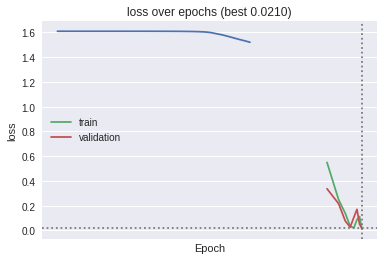

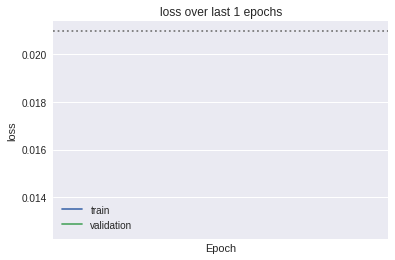

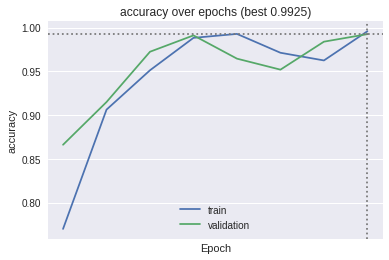

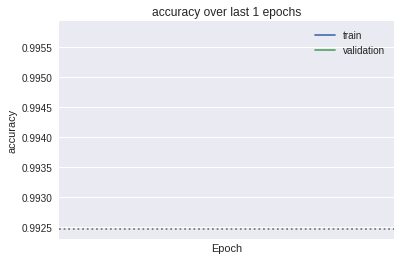


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 1s 10ms/step - loss: 0.0269 - accuracy: 0.9921
Confusion matrix, without normalization
[[943   0   3]
 [  0 910   3]
 [  9   7 910]]

****** Validation data (unseen to model) *****

184/184 [==============================] - 2s 8ms/step - loss: 0.9619 - accuracy: 0.9095
Confusion matrix, without normalization
[[1903    0   50]
 [   0 1860   93]
 [  22  365 1566]]
Final Accuracy: 90.95 %

10 fold acc: [90.95]


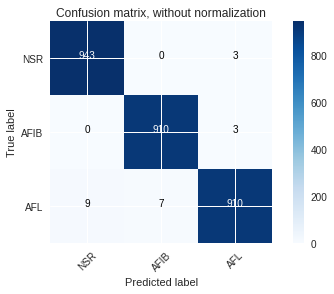

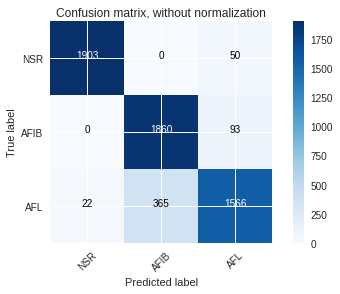

In [39]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,7)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  break
print("10 fold acc:",all_fold_acc)

In [51]:
m_resnet_model = get_resnet_model(7)
m_resnet_model.load_weights('weights.hdf5')

In [70]:
X_ckecker=test_data.iloc[:,:-1].values

In [71]:
preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

In [72]:
test_data['predicted_class']=preds

In [78]:
dct= {0:'nsr', 1:'afib', 2:'afl'}
test_data=test_data.replace({"predicted_class": dct})

In [77]:
test_data['predicted_class'].value_counts()

afib    3699
afl     3074
nsr      560
Name: predicted_class, dtype: int64

In [80]:
test_data.to_csv("result_arr_ppg_RRi.csv",index=False)